In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

loss_folder = 'neural_odes/loss'
os.makedirs(loss_folder, exist_ok=True)

es_cb = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

In [2]:
# Load the dataset
df =  pd.read_csv('C:/Users/criju/Documents/Cod-Thesis-2/data/serie.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Functions for data processing and model building
def create_intervals(df):
    """
    Divide un DataFrame en 8 intervalos regulares basados en la columna 'Fecha',
    grafica los datos y devuelve los intervalos.
    """
    fecha_min = df['Fecha'].min()
    fecha_max = df['Fecha'].max()
    bins = pd.date_range(start=fecha_min, end=fecha_max, periods=9)  # 9 puntos para generar 8 intervalos
    df['Intervalo'] = pd.cut(df['Fecha'], bins=bins, include_lowest=True, right=False)
    intervalos_ordenados = sorted(df['Intervalo'].dropna().unique(), key=lambda x: x.left)
    return intervalos_ordenados

def build_lstm_model(window_size):
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(window_size, 1), dropout=0.2),
        Dense(32),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


def create_windows(data, window_size):
    """
    Genera secuencias (ventanas) a partir de la serie de tiempo.
    
    Args:
        data (np.array): Valores escalados de la serie.
        window_size (int): Longitud de la ventana.
        
    Returns:
        tuple: Arrays (x, y) donde x son las secuencias y y el valor a predecir.
    """
    x = []
    y = []
    for i in range(len(data) - window_size):
        x.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(x), np.array(y)

def smape(y_true, y_pred, eps=1e-8):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return 100 * np.mean(numerator / (denominator + eps))

Iteración 1: Mejor época = 50, Loss = 0.0723
Intervalos 1 a 1: MAE = 64.94, MSE = 6874.73


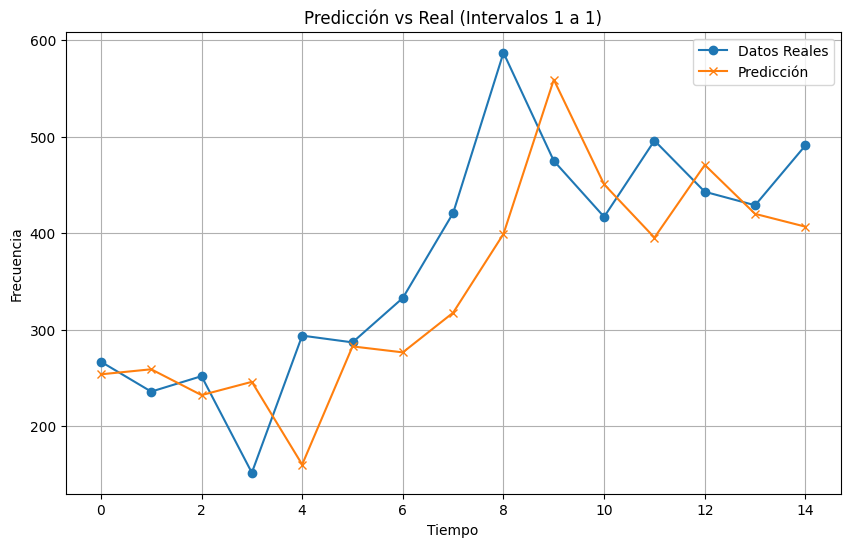

Iteración 2: Mejor época = 47, Loss = 0.0275
Intervalos 1 a 2: MAE = 113.30, MSE = 19965.43


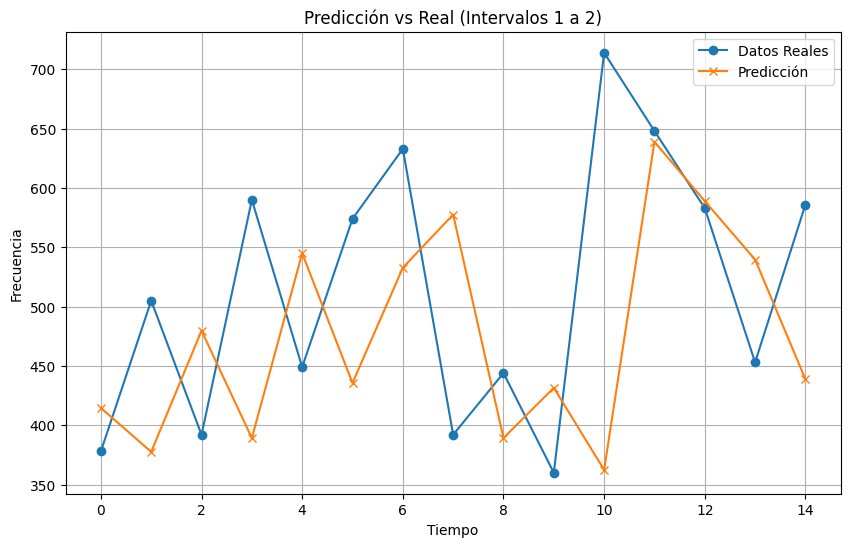

Iteración 3: Mejor época = 49, Loss = 0.0407
Intervalos 1 a 3: MAE = 222.59, MSE = 68864.37


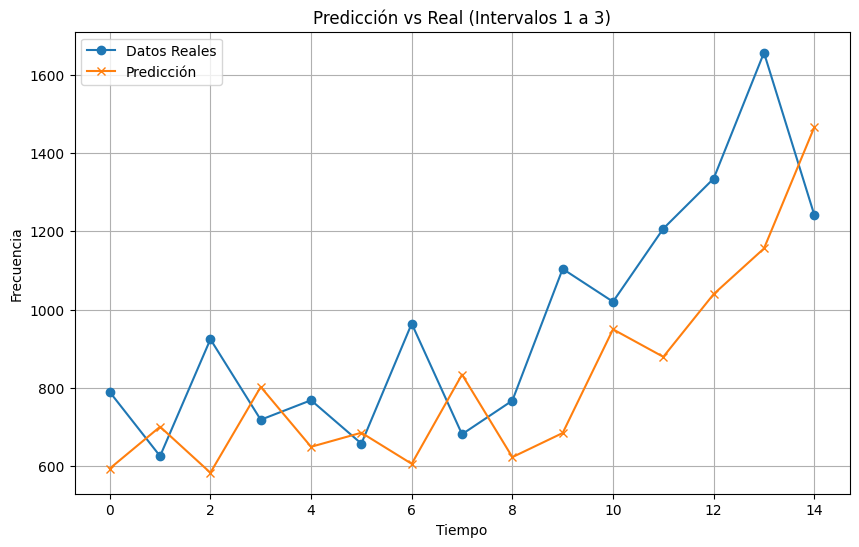

Iteración 4: Mejor época = 46, Loss = 0.1195
Intervalos 1 a 4: MAE = 9.50, MSE = 129.46


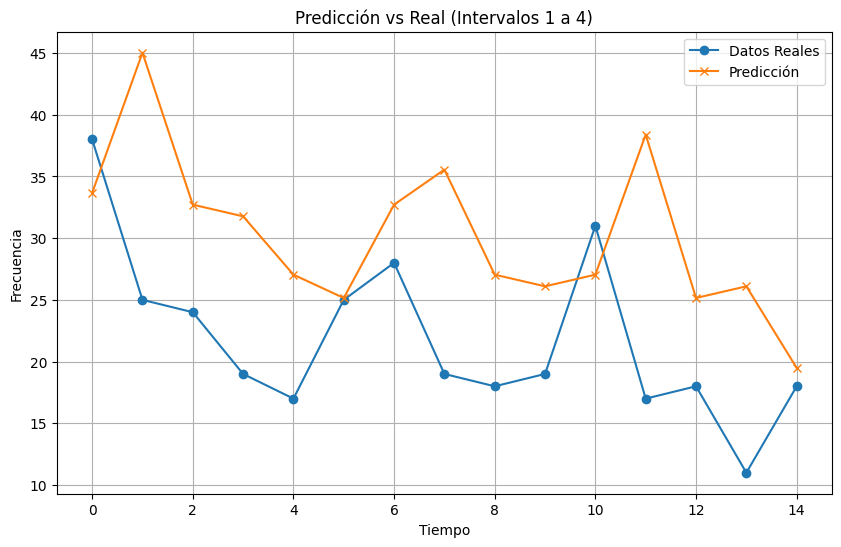

Iteración 5: Mejor época = 50, Loss = 0.1169
Intervalos 1 a 5: MAE = 60.04, MSE = 4799.98


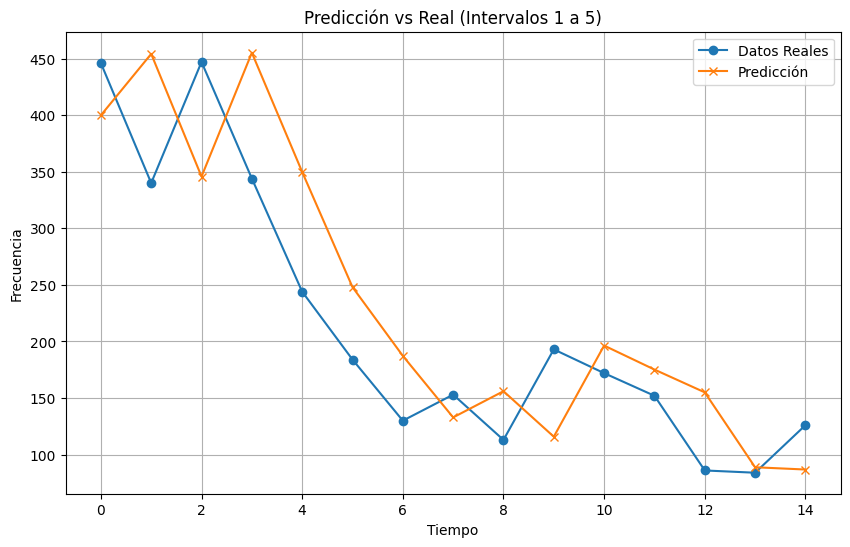

Iteración 6: Mejor época = 45, Loss = 0.1059
Intervalos 1 a 6: MAE = 19.94, MSE = 639.13


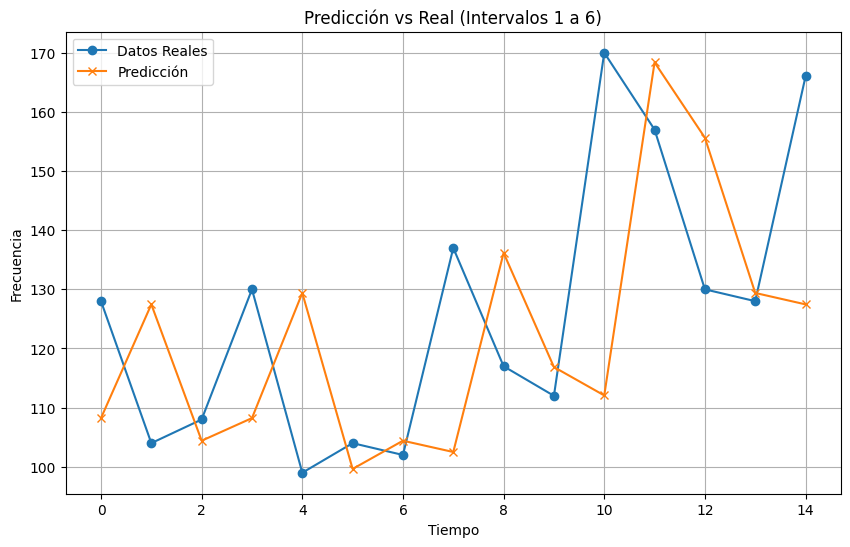

Iteración 7: Mejor época = 50, Loss = 0.1076
Intervalos 1 a 7: MAE = 11.61, MSE = 253.31


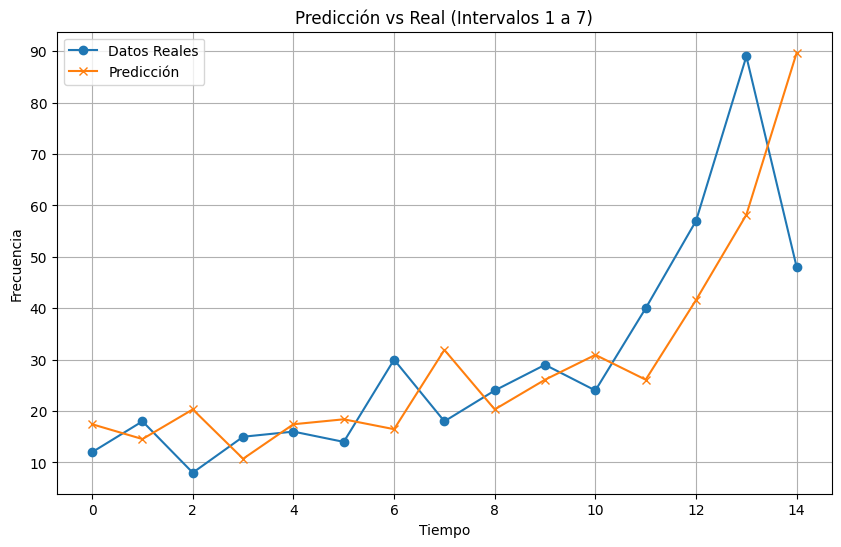

Iteración 8: Mejor época = 50, Loss = 0.1112
Intervalos 1 a 8: MAE = 3.93, MSE = 26.03


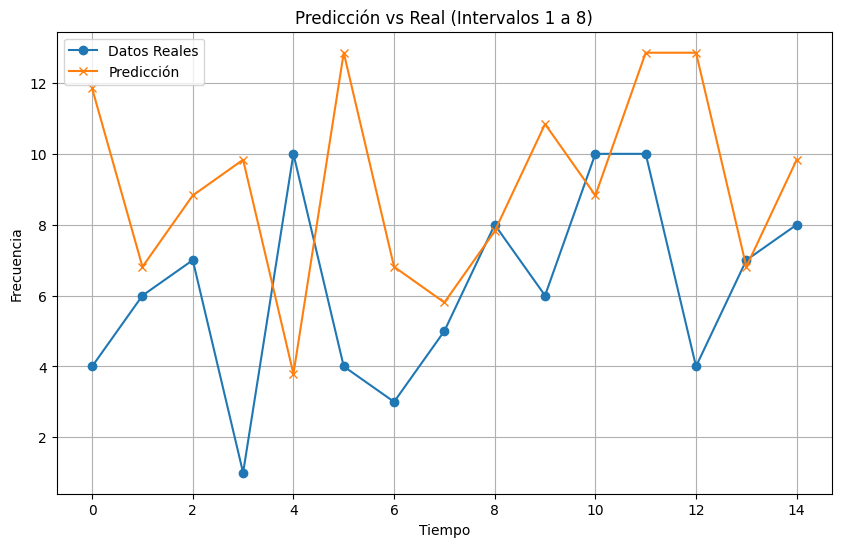


Resumen de métricas:
  Intervalos Acumulados         MAE           MSE      SMAPE
0      Intervalos 1 a 1   64.941284   6874.733398  19.199486
1      Intervalos 1 a 2  113.304932  19965.427734  23.109011
2      Intervalos 1 a 3  222.591644  68864.367188  24.426456
3      Intervalos 1 a 4    9.501300    129.460953  37.180840
4      Intervalos 1 a 5   60.040936   4799.982910  27.831013
5      Intervalos 1 a 6   19.941862    639.126709  15.562874
6      Intervalos 1 a 7   11.605962    253.312180  37.079800
7      Intervalos 1 a 8    3.927880     26.029203  54.074604


In [3]:
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, x):
        return self.net(x)

# Modelo completo con ODE
class NeuralODEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = ODEFunc()

    def forward(self, x):
        t = torch.linspace(0, 1, x.shape[1])
        out = []
        for i in range(x.shape[0]):
            xi = x[i].view(-1, 1)
            yi = odeint(self.odefunc, xi[-1:], t)[-1]
            out.append(yi)
        return torch.cat(out, dim=0)

WINDOW_SIZE = 7
HORIZONTE = 15
EPOCHS = 50
BATCH_SIZE = 16
loss_folder = "./loss_plots"
os.makedirs(loss_folder, exist_ok=True)

# Supongamos que tienes df cargado
# df = pd.read_csv("tu_serie.csv")
intervalos_ordenados = create_intervals(df)
resultados = []
scaler = RobustScaler()

for i in range(len(intervalos_ordenados)):
    intervalos_incluir = intervalos_ordenados[:i+1]
    df_train = df[df['Intervalo'].isin(intervalos_incluir)].sort_values(by='Fecha')
    series = df_train['Frecuencia'].values.reshape(-1, 1)
    series_scaled = scaler.fit_transform(series)

    if len(series_scaled) <= WINDOW_SIZE + HORIZONTE:
        print(f"Iteración {i+1}: No hay suficientes datos")
        continue

    train_data = series_scaled[:-HORIZONTE]
    test_data = series_scaled[-(HORIZONTE + WINDOW_SIZE):]
    x_train, y_train = create_windows(train_data, WINDOW_SIZE)
    x_test, y_test = create_windows(test_data, WINDOW_SIZE)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    model = NeuralODEModel()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    loss_vals = []
    for epoch in range(EPOCHS):
        model.train()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.item())

    best_epoch = int(np.argmin(loss_vals)) + 1
    best_loss = loss_vals[best_epoch - 1]
    print(f"Iteración {i+1}: Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # Plot de pérdida
    plt.figure(figsize=(8,5))
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(range(1, EPOCHS + 1), loss_vals, marker='o')
    plt.axvline(best_epoch, color='gray', linestyle='--', label=f"Best epoch ({best_epoch})")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title(f"Entrenamiento Intervalos 1 a {i+1}")
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(loss_folder, f"neural_ode_loss_{i+1}.png"), dpi=300)
    plt.close()

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test).numpy()

    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1,1))

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    smape_value = smape(y_test_inv, y_pred_inv)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })

    print(f"Intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label="Datos Reales", marker='o')
    plt.plot(y_pred_inv, label="Predicción", marker='x')
    plt.title(f"Predicción vs Real (Intervalos 1 a {i+1})")
    plt.xlabel("Tiempo")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()

# Exportar resultados
resultados_df = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(resultados_df)
resultados_df.to_csv("./resultados_neural_ode.csv", index=False)